<a href="https://colab.research.google.com/github/Gayavi/Machine-Learning/blob/main/SVM_With_Kernels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The link for the blog is https://medium.com/@gayavisandeepi/using-svm-with-kernels-to-predict-whether-a-client-will-subscribe-a-term-deposit-7755da5481c6

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn import svm, datasets
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Importing necessary imports

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Mounting the google drive to the google colab notebook

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/data/banking.csv')
df.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,210,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,138,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,339,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,185,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,137,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1
5,30,management,divorced,basic.4y,no,yes,no,cellular,jul,tue,68,8,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,0
6,37,blue-collar,married,basic.4y,no,yes,no,cellular,may,thu,204,1,999,0,nonexistent,-1.8,92.893,-46.2,1.327,5099.1,0
7,39,blue-collar,divorced,basic.9y,no,yes,no,cellular,may,fri,191,1,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,0
8,36,admin.,married,university.degree,no,no,no,cellular,jun,mon,174,1,3,1,success,-2.9,92.963,-40.8,1.266,5076.2,1
9,27,blue-collar,single,basic.4y,no,yes,no,cellular,apr,thu,191,2,999,1,failure,-1.8,93.075,-47.1,1.410,5099.1,0


Dataset

# **Handling missing values and duplicates**

In [ ]:
df.isnull().any()

age               False
job               False
marital           False
education         False
default           False
housing           False
loan              False
contact           False
month             False
day_of_week       False
duration          False
campaign          False
pdays             False
previous          False
poutcome          False
emp_var_rate      False
cons_price_idx    False
cons_conf_idx     False
euribor3m         False
nr_employed       False
y                 False
dtype: bool

There are no any missing values

In [ ]:
print(df.duplicated().value_counts())

False    41176
True        12
dtype: int64


There are 12 duplicates

In [ ]:
df=df.drop_duplicates()
print(df.duplicated().value_counts())

False    41176
dtype: int64


Duplicates have been dropped

In [ ]:
df=df.drop(['duration'],axis=1)

Drop the duration column as duration attribute highly affects the output target

# **Handling outliers**

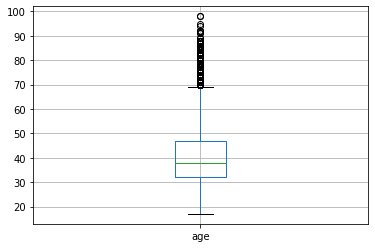

In [ ]:
df.boxplot(column=['age'])

No outliers

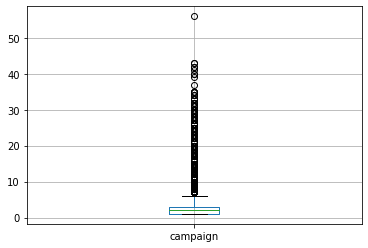

In [ ]:
df.boxplot(column=['campaign'])

In [ ]:
df['campaign'].count()

41176

In [ ]:
df=df.drop(df[df['campaign'] >50].index)

In [ ]:
df['campaign'].count()

41175

There has been one outlier and it was dropped

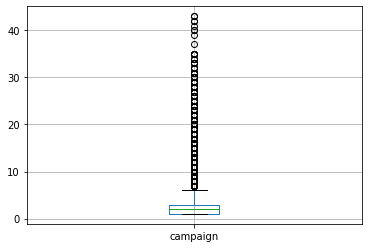

In [ ]:
df.boxplot(column=['campaign'])

Boxplot of campaign after removing duplicates

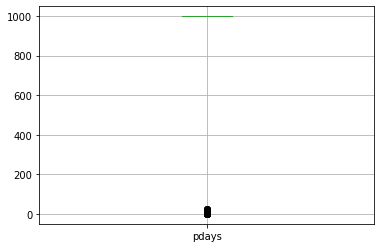

In [ ]:
df.boxplot(column=['pdays'])

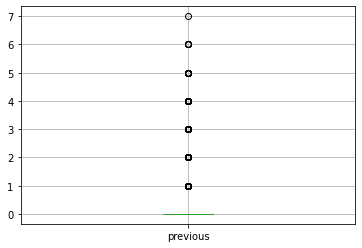

In [ ]:
df.boxplot(column=['previous'])

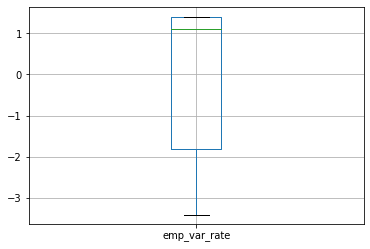

In [ ]:
df.boxplot(column=['emp_var_rate'])

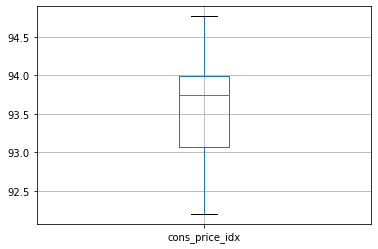

In [ ]:
df.boxplot(column=['cons_price_idx'])

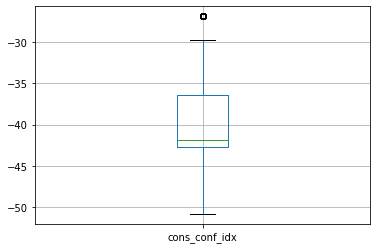

In [ ]:
df.boxplot(column=['cons_conf_idx'])


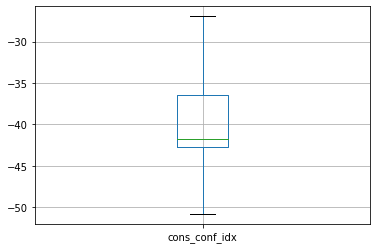

In [ ]:
Q1 = df["cons_conf_idx"].quantile(0.25)
Q3 = df["cons_conf_idx"].quantile(0.75)
IQR = Q3-Q1

lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR

df['cons_conf_idx'] = np.where(df['cons_conf_idx']>upper_limit,upper_limit,df['cons_conf_idx'])
df['cons_conf_idx'] = np.where(df['cons_conf_idx']<lower_limit,lower_limit,df['cons_conf_idx'])
df.boxplot(column=['cons_conf_idx'])

Boxplot of cons_conf_idx after replacing outliers with upperlimit and lower limit

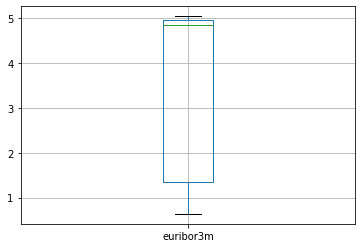

In [ ]:
df.boxplot(column=['euribor3m'])


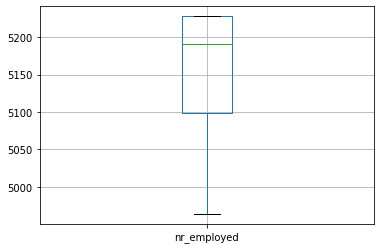

In [ ]:
df.boxplot(column=['nr_employed'])    

# **Feature transformations**

*  Q-Q Plots*

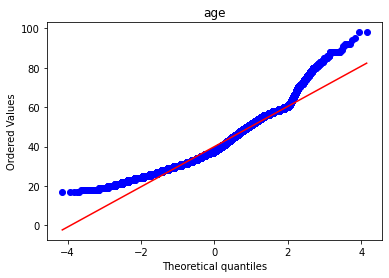

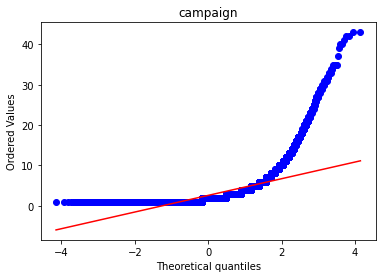

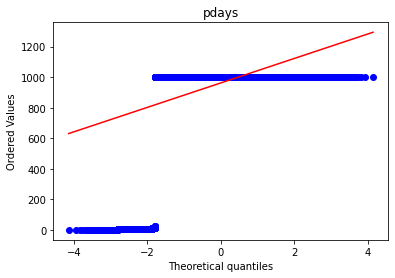

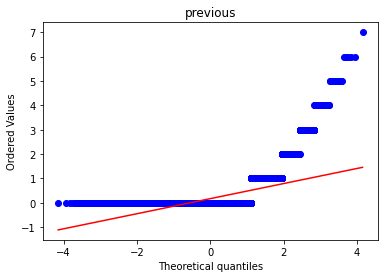

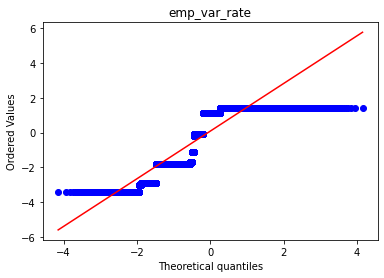

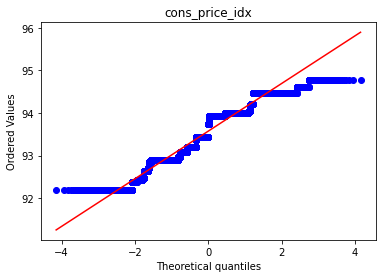

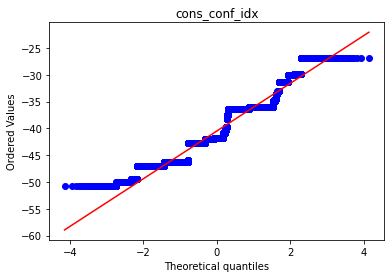

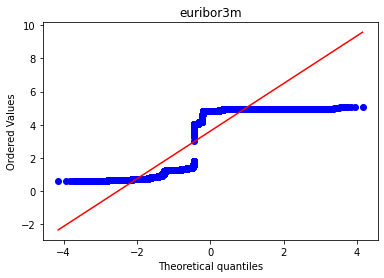

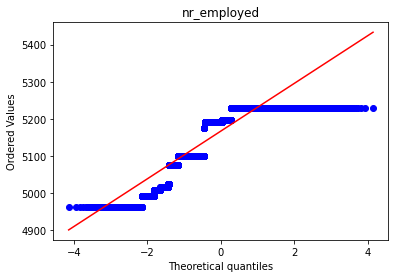

In [ ]:
stats.probplot(df["age"], dist="norm", plot=plt)
plt.title("age")
plt.show()
stats.probplot(df["campaign"], dist="norm", plot=plt)
plt.title("campaign")
plt.show()
stats.probplot(df["pdays"], dist="norm", plot=plt)
plt.title("pdays")
plt.show()
stats.probplot(df["previous"], dist="norm", plot=plt)
plt.title("previous")
plt.show()
stats.probplot(df["emp_var_rate"], dist="norm", plot=plt)
plt.title("emp_var_rate")
plt.show()
stats.probplot(df["cons_price_idx"], dist="norm", plot=plt)
plt.title("cons_price_idx")
plt.show()
stats.probplot(df["cons_conf_idx"], dist="norm", plot=plt)
plt.title("cons_conf_idx")
plt.show()
stats.probplot(df["euribor3m"], dist="norm", plot=plt)
plt.title("euribor3m")
plt.show()
stats.probplot(df["nr_employed"], dist="norm", plot=plt)
plt.title("nr_employed")
plt.show()

Histograms

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f98904a5cd0>,
      dtype=object)

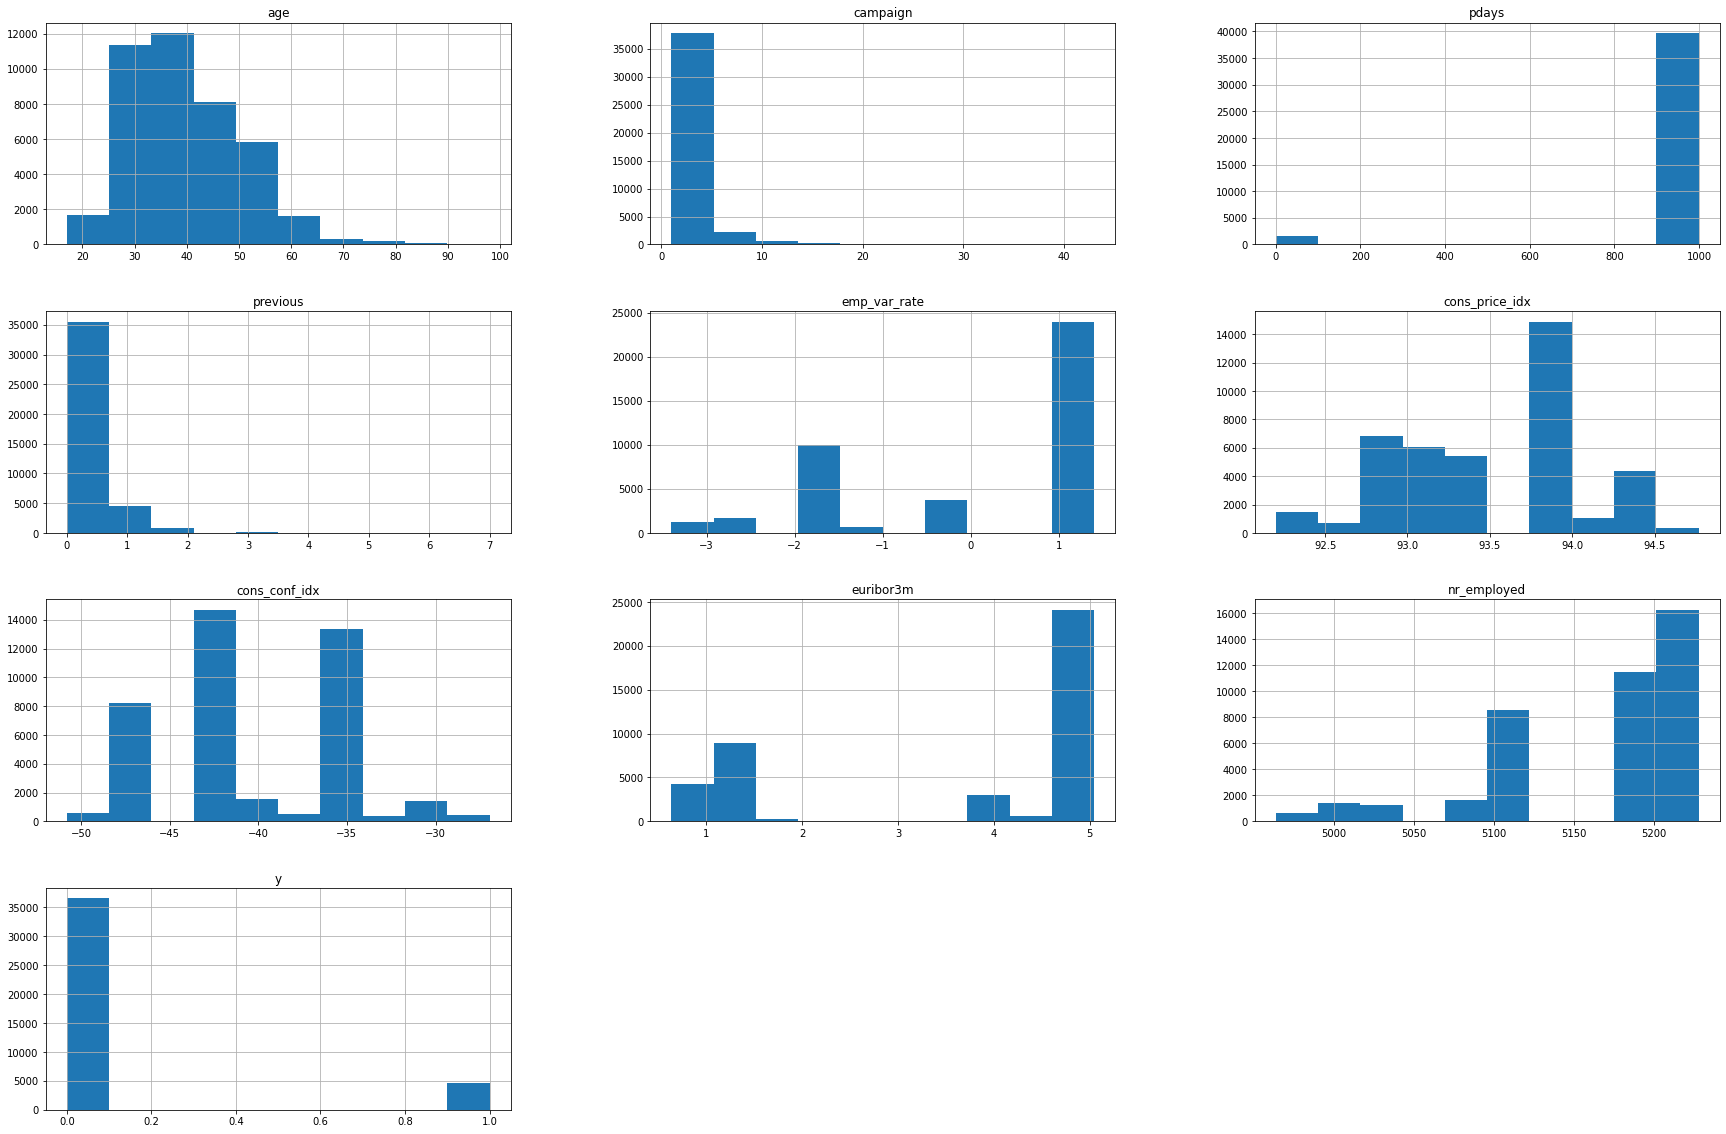

In [ ]:
df.hist(figsize=(30,20))

age,previous and campaign columns are right skewed,
nr_employed and emp_var_rate columns are left skewed

*Handling right skewenes*

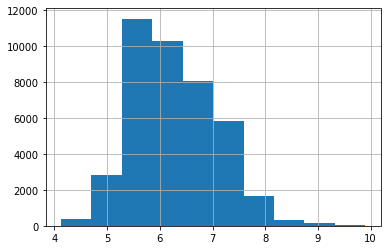

In [ ]:
df_new=df.copy()
sqrt_transformer = FunctionTransformer(np.sqrt)

new_age= sqrt_transformer.transform(df_new['age'])
df_new['age']=new_age
df_new['age'].hist()

age after transformations

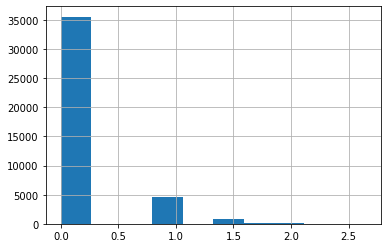

In [ ]:
new_previous= sqrt_transformer.transform(df_new['previous'])
df_new['previous']=new_previous
df_new['previous'].hist()

previous after transformations

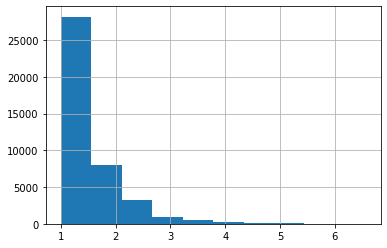

In [ ]:
new_campaign= sqrt_transformer.transform(df_new['campaign'])
df_new['campaign']=new_campaign
df_new['campaign'].hist()

campaign after transformations

*Handling left skewness*

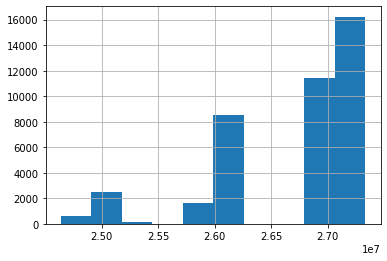

In [ ]:
squared_transformer = FunctionTransformer(lambda x:x**2)

new_nr_employed = squared_transformer.transform(df_new['nr_employed'])
df_new['nr_employed']= new_nr_employed
df_new['nr_employed'].hist()

nr_employed after transformations

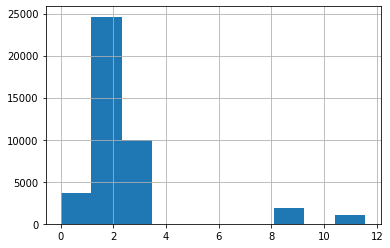

In [ ]:
new_emp_var_rate = squared_transformer.transform(df_new['emp_var_rate'])
df_new['emp_var_rate']= new_emp_var_rate
df_new['emp_var_rate'].hist()

emp_var_rate after transformations

# **Feature encoding**

In [ ]:
df_new['job']=df_new['job'].astype('category').cat.codes
df_new['marital']=df_new['marital'].astype('category').cat.codes
df_new['education']=df_new['education'].astype('category').cat.codes
df_new['default']=df_new['default'].astype('category').cat.codes
df_new['housing']=df_new['housing'].astype('category').cat.codes
df_new['loan']=df_new['loan'].astype('category').cat.codes
df_new['contact']=df_new['contact'].astype('category').cat.codes
df_new['month']=df_new['month'].astype('category').cat.codes
df_new['day_of_week']=df_new['day_of_week'].astype('category').cat.codes
df_new['poutcome']=df_new['poutcome'].astype('category').cat.codes
df_new

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,6.633250,1,1,0,1,2,0,0,1,2,1.000000,999,0.000000,1,1.96,93.444,-36.10,4.963,27333029.61,0
1,7.280110,9,1,7,0,0,0,0,7,0,1.000000,999,0.000000,1,0.01,93.200,-42.00,4.021,26996337.64,0
2,5.291503,4,2,6,0,2,0,0,4,2,1.732051,6,1.414214,2,2.89,94.055,-39.80,0.729,24916070.56,1
3,6.244998,7,1,3,0,0,0,0,0,0,1.414214,999,0.000000,1,3.24,93.075,-47.10,1.405,26000820.81,0
4,7.416198,5,1,0,0,2,0,0,1,0,1.000000,3,1.000000,2,8.41,92.201,-31.40,0.869,25767806.44,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,7.681146,5,1,3,1,0,2,1,4,2,1.000000,999,0.000000,1,1.96,94.465,-41.80,4.866,27333029.61,0
41184,5.567764,3,1,0,1,0,0,1,6,2,1.414214,999,0.000000,1,1.21,93.994,-36.40,4.860,26946481.00,0
41185,6.480741,0,2,6,1,2,2,1,6,4,1.732051,999,0.000000,1,1.21,93.994,-36.40,4.857,26946481.00,0
41186,6.928203,9,1,5,0,0,2,1,8,3,1.414214,999,0.000000,1,11.56,92.431,-26.95,0.742,25175306.25,0


Results after label encoding

# **Feature scaling**

In [ ]:
columnfeatures=['age','campaign','pdays','previous','emp_var_rate','cons_price_idx','cons_conf_idx','euribor3m','nr_employed']
scaler = StandardScaler() 

scaler.fit(df_new[columnfeatures])
df_new[columnfeatures]=scaler.transform(df_new[columnfeatures])
df_new

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,0.445094,1,1,0,1,2,0,0,1,2,-0.777914,0.195446,-0.388096,1,-0.233463,-0.227543,0.951857,0.773591,0.849370,0
1,1.248893,9,1,7,0,0,0,0,7,0,-0.777914,0.195446,-0.388096,1,-1.118558,-0.649079,-0.323481,0.230472,0.395127,0
2,-1.222184,4,2,6,0,2,0,0,4,2,0.410968,-5.116504,3.258902,2,0.188660,0.828025,0.152069,-1.667562,-2.411437,1
3,-0.037355,7,1,3,0,0,0,0,0,0,-0.105214,0.195446,-0.388096,1,0.347523,-0.865030,-1.425891,-1.277808,-0.947961,0
4,1.417999,5,1,0,0,2,0,0,1,0,-0.777914,-5.132552,2.190721,2,2.694159,-2.374958,1.967803,-1.586844,-1.262329,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,1.747227,5,1,3,1,0,2,1,4,2,-0.777914,0.195446,-0.388096,1,-0.233463,1.536344,-0.280249,0.717665,0.849370,0
41184,-0.878897,3,1,0,1,0,0,1,6,2,-0.105214,0.195446,-0.388096,1,-0.573884,0.722641,0.887009,0.714205,0.327864,0
41185,0.255583,0,2,6,1,2,2,1,6,4,0.410968,0.195446,-0.388096,1,-0.573884,0.722641,0.887009,0.712476,0.327864,0
41186,0.811608,9,1,5,0,0,2,1,8,3,-0.105214,0.195446,-0.388096,1,4.123928,-1.977609,2.929711,-1.660067,-2.061692,0


Results after standardization

# **Correlation matrix**

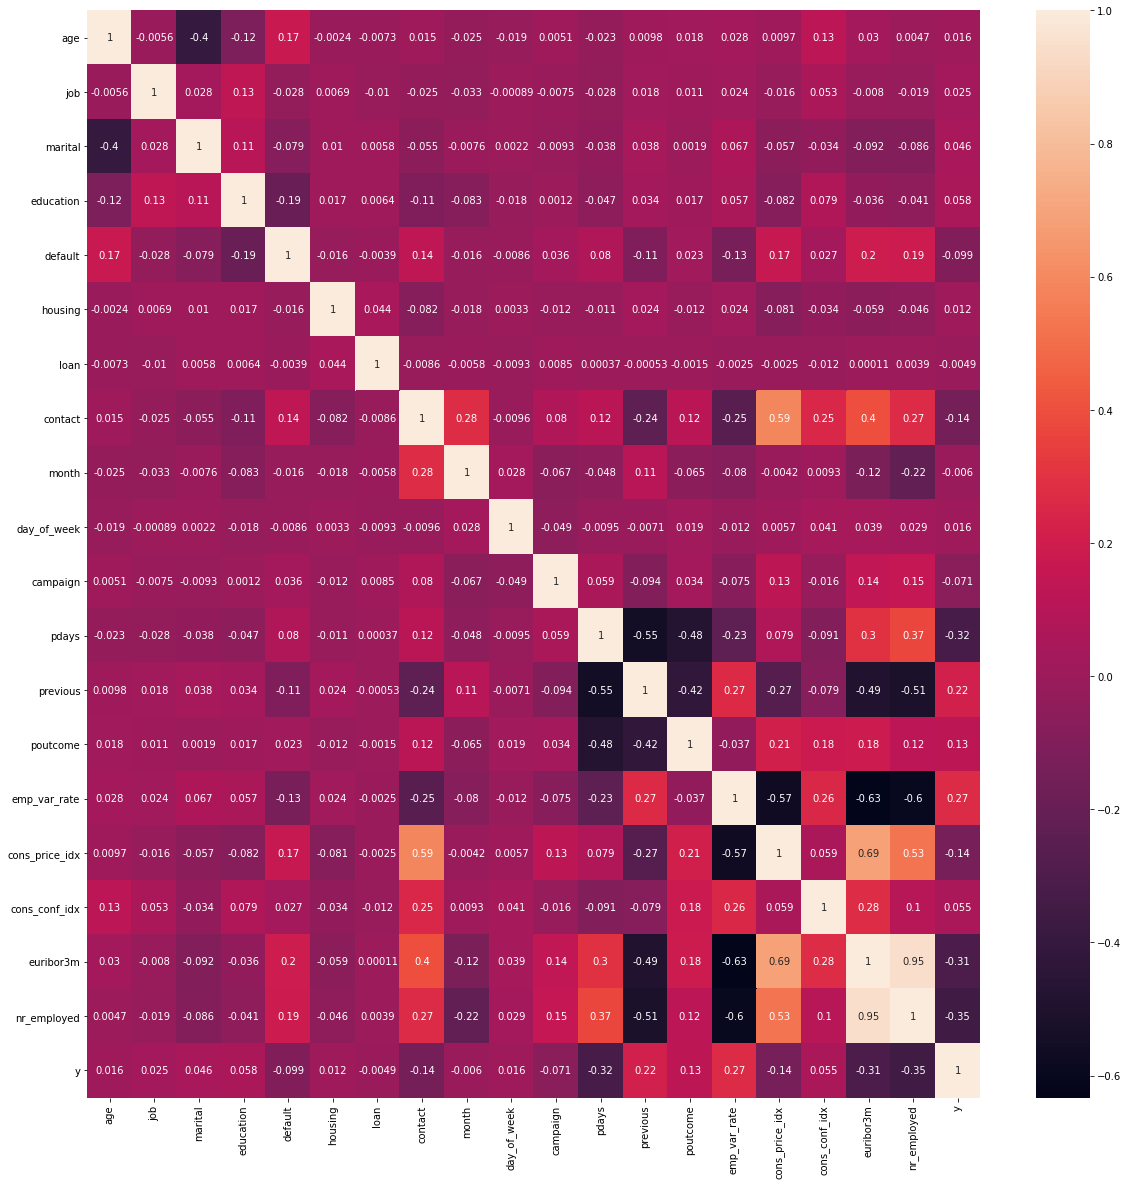

In [ ]:
plt.figure(figsize = (20,20))
sns.heatmap(df_new.corr(),annot = True);
plt.savefig('svm_conf.png', dpi=400)

In [ ]:
df_new = df_new.drop(['month','loan','age','day_of_week','housing'], axis = 1)

There are no highly correlated attributes and 'month','loan','age','day_of_week','housing' attributes are less significant when compared with other attributes. Therefore those attributes were dropped

# **SMOTE**

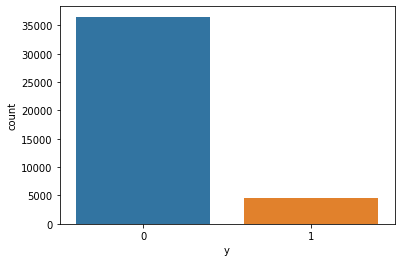

In [ ]:
df_new['y'].value_counts()
sns.countplot(x='y', data=df_new)
plt.show()

y attributes has a class imbalance

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


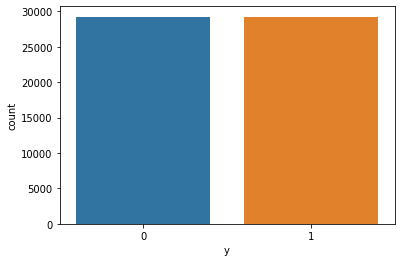

In [ ]:
y=df_new['y']
x=df_new.drop(['y'],axis=1)
X_class_train, X_test, y_class_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

os = SMOTE(random_state=0)
data_X, data_y = os.fit_sample(X_class_train, y_class_train)

columns = X_class_train.columns
smoted_X = pd.DataFrame(data=data_X,columns=columns )
smoted_y= pd.DataFrame(data=data_y,columns=['y'])
sns.countplot(x='y', data=smoted_y)
plt.show()

Class imbalance which was in y attribute was removed

# **PCA**

In [ ]:
train_X=smoted_X
y_train=smoted_y
pca = PCA(n_components=7)
pca.fit(train_X)
X_train= pca.transform(train_X)
test_X = pca.transform(X_test)
pca.explained_variance_ratio_

array([0.43273039, 0.1899665 , 0.14168892, 0.0862032 , 0.05300772,
       0.02410758, 0.02248246])

Applying PCA for 7 components and getting the variance ratio

In [ ]:
pca.explained_variance_ratio_[:7].sum()

0.9501867799196813

Sum of variance ratio

# **SVM with kernels**

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.94      0.85      0.90      7306
           1       0.34      0.61      0.44       929

    accuracy                           0.82      8235
   macro avg       0.64      0.73      0.67      8235
weighted avg       0.88      0.82      0.84      8235



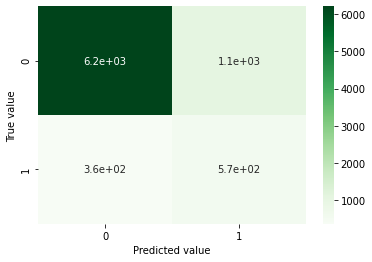

In [ ]:
trainedsvm = svm.SVC(kernel='rbf', C=50, gamma=0.05).fit(X_train,y_train)
predictionsvm = trainedsvm.predict(test_X)

print(classification_report(y_test,predictionsvm))
confusion_matrix = confusion_matrix(y_test,predictionsvm)
fig, ax = plt.subplots(1)
ax = sns.heatmap(confusion_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
plt.ylabel('True value')
plt.xlabel('Predicted value')
plt.show()


Classification report and confusion matrix after applying SVM with kernel

In [ ]:
print("Precision: {}".format(precision_score(y_test,predictionsvm)))
print("Recall: {}".format(recall_score(y_test,predictionsvm)))
print("F1-Score: {}".format(f1_score(y_test,predictionsvm)))

Precision: 0.3413751507840772
Recall: 0.6092572658772875
F1-Score: 0.4375724777734828


Precision,recall and F1-Score of predictions done by the model

# **Thank you**